In [58]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score

!gdown 1ERwQ5odiK1Zvi1LtjpkzCMUswYsAX8_K  # train.csv
!gdown 1fGw_-RFwvn_LEdt91Jq-7A-wzG6mmH8r  # test.csv
!gdown 199Mt4OYZNaelT83U-HGDsEYs2YcUGQ6y  # submission.csv

data = pd.read_csv('./train.csv')

Downloading...
From: https://drive.google.com/uc?id=1ERwQ5odiK1Zvi1LtjpkzCMUswYsAX8_K
To: /content/train.csv
100% 664k/664k [00:00<00:00, 26.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1fGw_-RFwvn_LEdt91Jq-7A-wzG6mmH8r
To: /content/test.csv
100% 218k/218k [00:00<00:00, 16.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=199Mt4OYZNaelT83U-HGDsEYs2YcUGQ6y
To: /content/submission.csv
100% 14.7k/14.7k [00:00<00:00, 45.7MB/s]


In [59]:
# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

# Новый раздел

In [60]:
data['TotalSpent'] = pd.to_numeric(data['TotalSpent'], errors='coerce')  # преобразуем в числовой формат str-значения TotalSpent

In [61]:
random_rows = data.sample(n=5)  # 5 случайных строк
print(random_rows)

      ClientPeriod  MonthlySpending  TotalSpent     Sex  IsSeniorCitizen  \
2206             9            94.40      857.25  Female                0   
2328            33            20.15      682.15    Male                0   
2709             1            89.90       89.90    Male                0   
3316            11            84.80      906.85  Female                1   
4859             5            82.75      417.75  Female                0   

     HasPartner HasChild HasPhoneService HasMultiplePhoneNumbers  \
2206         No       No             Yes                     Yes   
2328         No      Yes             Yes                      No   
2709         No       No             Yes                      No   
3316         No       No             Yes                     Yes   
4859         No       No             Yes                     Yes   

     HasInternetService HasOnlineSecurityService      HasOnlineBackup  \
2206        Fiber optic                       No             

In [62]:
nan_values = data.isna().sum()  # Количество NaN значений в каждом столбце (там будет 9 NaN, так как мы корректировали формат данных числового признака - далее исправляем этот момент)
print(nan_values)

ClientPeriod                0
MonthlySpending             0
TotalSpent                  9
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64


In [63]:
data.dropna(subset=['TotalSpent'], inplace=True) # Поскольку не так много значений NaN в TotalSpent, мне кажется корректно от них избавиться

In [64]:
nan_values = data.isna().sum()  # Количество NaN значений в каждом столбце (Теперь всё хорошо)
print(nan_values)

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64


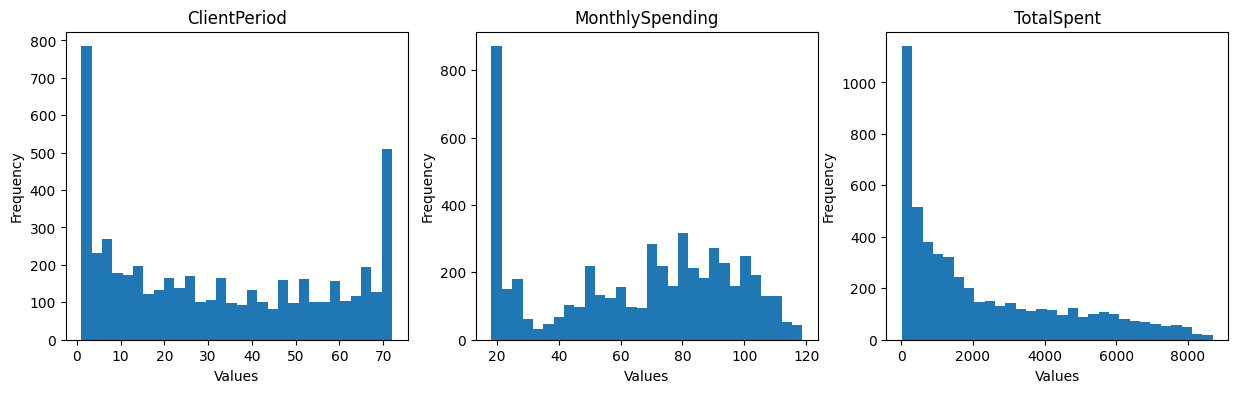

In [65]:
# Гистограммы числовых признаков
fig, axes = plt.subplots(1, len(num_cols), figsize=(15, 4))

for i, col in enumerate(num_cols):
    axes[i].hist(data[col], bins=30)
    axes[i].set_xlabel('Values')
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(col)

plt.show()

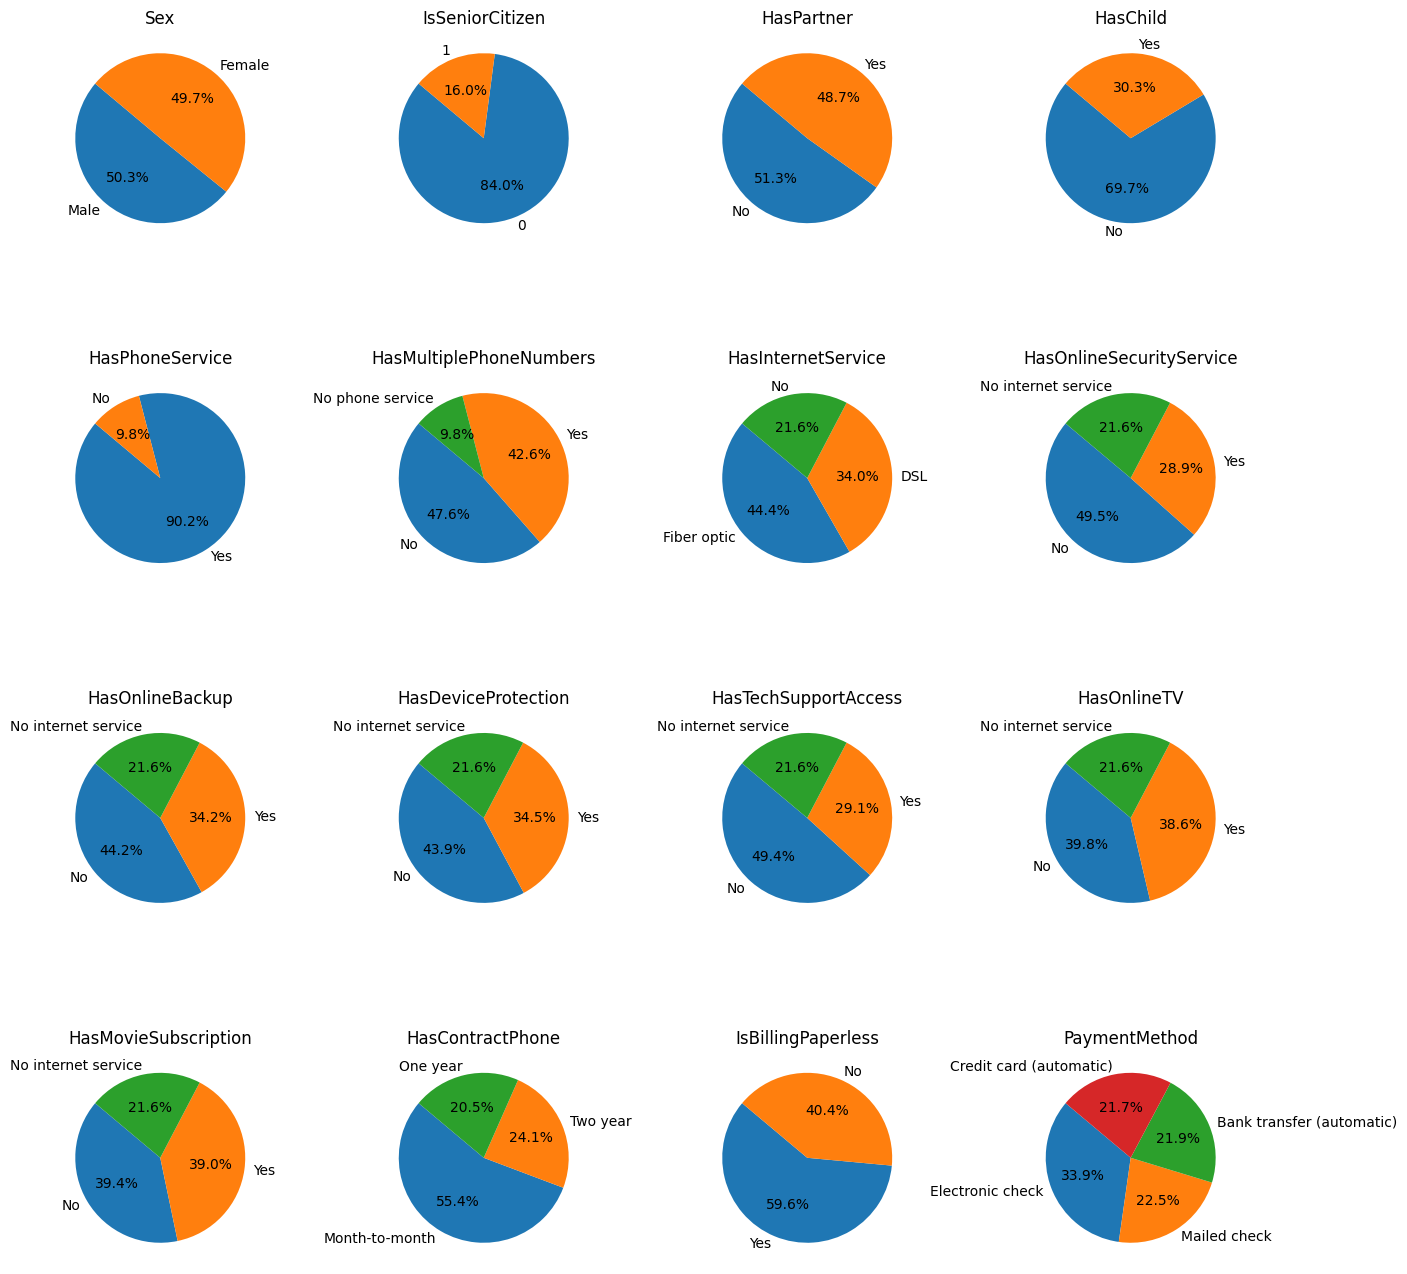

In [66]:
# Круговые диаграммы категориальных признаков
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
fig.subplots_adjust(hspace=0.6)

for i, column in enumerate(cat_cols):

    value_counts = data[column].value_counts()
    row, col = divmod(i, 4)
    axes[row, col].pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)
    axes[row, col].set_title(column)

plt.show()



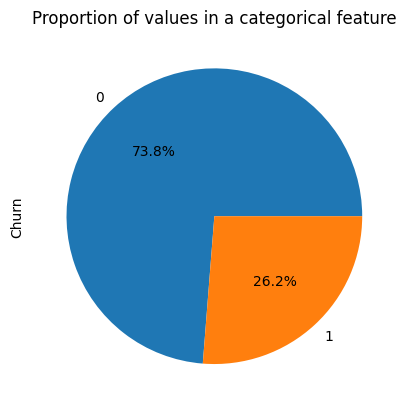

In [67]:
# Анализ целевой переменной

category_counts = data[target_col].value_counts()

category_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('Proportion of values in a categorical feature')
plt.show()


In [68]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline

In [69]:
# Нормализация числовых признаков
scaler = StandardScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])

# Применение one-hot-encoding к категориальным признакам
encoded_cat_cols = pd.get_dummies(data[cat_cols], columns=cat_cols)

# Объединение числовых и закодированных категориальных признаков
processed_data = pd.concat([data[num_cols], encoded_cat_cols], axis=1)


In [70]:
# Разделение на train/valid
X_train, X_valid, y_train, y_valid = train_test_split(processed_data, data[target_col], test_size=0.2, random_state=42)

# Создание объекта LogisticRegressionCV
log_reg_cv = LogisticRegressionCV(Cs=[100, 10, 1, 0.1, 0.01, 0.001], scoring='roc_auc', refit=True, cv=5, max_iter=1000)

# Обучение модели
log_reg_cv.fit(X_train, y_train)

# Лучший параметр C
best_C = log_reg_cv.C_[0]

# Оценка качества на валидационной выборке
roc_auc = log_reg_cv.score(X_valid, y_valid)

print(best_C)
print(roc_auc)

10.0
0.8439679169615475


In [ ]:
!pip install catboost
from catboost import CatBoostClassifier

In [71]:
X = data[feature_cols]
y = data[target_col]

# Задаём тестовую и валидационную часть
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

# Задаём переменные для необходимого по условию задачи вывода
best_auc = 0
best_params = {'n_estimators': 0, 'learning_rate': 0}

# В цикле задаем и обучаем модель, измеряем качество параметров по метрике ROC-AUC, записываем что дало лучший результат
for n_estimators in [100, 125, 150]:
    for learning_rate in [0.1, 0.11, 0.12]:
        model = CatBoostClassifier(
            cat_features=cat_cols, n_estimators=n_estimators, learning_rate=learning_rate, verbose=0)
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_valid)[:, 1]
        auc = roc_auc_score(y_valid, y_pred)
        if auc > best_auc:
            best_auc = auc
            best_params = {'n_estimators': n_estimators, 'learning_rate': learning_rate}
print("Best auc:", best_auc)
print("Best parameters:", best_params)

Best auc: 0.8412802796969949
Best parameters: {'n_estimators': 100, 'learning_rate': 0.1}


In [72]:
# Задаём лучшие параметры для модели
best_model = CatBoostClassifier(
            cat_features=cat_cols, n_estimators=100, learning_rate=0.1, verbose=0)
best_model.fit(X_train, y_train)

In [57]:
X_test = pd.read_csv('./test.csv')
submission = pd.read_csv('./submission.csv')

churn_proba = best_model.predict_proba(X_test)[:, 1]

submission['Churn'] = churn_proba
submission.to_csv('./my_submission.csv', index=False)